In [ ]:
from nbdev.showdoc import *
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import FRED
if torch.__version__[:4] == '1.14': # If using pytorch with MPS, use Apple silicon GPU acceleration
    device = torch.device("cuda" if torch.cuda.is_available() else 'mps' if torch.has_mps else "cpu")
else:
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device", device)
# sns.set_theme()
%load_ext autoreload
%autoreload 2

Using device cpu


# 05d01 UW Method on Single Cell Datasets
> Run the UW model on all of our toy datasets (optionally, do so many times), and produce training gifs and loss charts for each.

This is set up for the popular library `papermill`, which can parameterize and execute notebooks. 

First, we set the notebook-wide parameters, then run the cells. Papermill will create copies of the notebook with each parameter configuration given.

In [ ]:
notebook = "05d01 UW Method on Single Cell Datasets.ipynb"
dataset_name = "bone marrow"
sigma = 'automatic'
num_neighbors = 10

In [ ]:
# Parameters
notebook = "05d01 UW Comparison on sc.ipynb"
dataset_name = "dentategyrus"
sigma = "automatic"
num_neighbors = 20
output_label = "run_4"


# Set Up

In [ ]:
from FRED.datasets import double_helix, directed_swiss_roll_delayed, directed_sinh_branch, rnavelo, rnavelo_pcs
from FRED.data_processing import dataloader_from_ndarray, ManifoldWithVectorField
from torch.utils.data import DataLoader
import scvelo as scv
# choose correct dataset
if dataset_name == "bone marrow":
    adata = scv.datasets.bonemarrow()
    print("processing data with pcs")
    X, flow, labels, n_pcs = rnavelo_pcs(adata)
elif dataset_name == "dentategyrus":
    adata = scv.datasets.dentategyrus()
    print("processing data with pcs")
    X, flow, labels, n_pcs = rnavelo_pcs(adata)
elif dataset_name == "pancreas":
    adata = scv.datasets.pancreas()
    print("processing data with pcs")
    X, flow, labels, n_pcs = rnavelo_pcs(adata)

processing data with pcs
Normalized count data: X, spliced, unspliced.
Logarithmized X.


computing neighbors


OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


    finished (0:00:03) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities


    finished (0:00:00) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)
computing velocities


    finished (0:00:01) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)
computing velocity graph (using 1/10 cores)


  0%|          | 0/2930 [00:00<?, ?cells/s]

    finished (0:00:08) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding


    finished (0:00:00) --> added
    'velocity_pca', embedded velocity vectors (adata.obsm)


In [ ]:
X.shape

torch.Size([2930, 30])

We have to build a directed graph from this raw data, which will serve as input to the UW algorithm. 

In [ ]:
from FRED.data_processing import flashlight_affinity_matrix
A = flashlight_affinity_matrix(X, flow, k=num_neighbors)
A = A.numpy()

Set sigma =  4.446951


## Set up the model

In [ ]:
import numpy as np
def UW_directed_embedding(W, m):
    """
    Replicates the velocity-embedding diffusion map from the UW paper.
    Input W, the directed graph, and m, the number of diffusion coordinates to keep.
    """
    # steps 1-6 (estimate coordinates according to diffusion map)
    # step 1
    S = (W + np.transpose(W))/2 # symmetric affinity matrix

    # step 2
    q = np.sum(S, axis = 1)
    Q = np.diag(q) # degree matrix

    # step 3
    Qinv = np.linalg.inv(Q)
    V = Qinv@S@Qinv # anisotropic normalized affinity matrix

    # step 4
    q1 = np.sum(V, axis=1)
    Q1 = np.diag(q) # normalized degree matrix
    Q1inv = np.linalg.inv(Q1) # 
    
    # step 5
    Hss = Q1inv@V # diffusion matrix (dividing affinity matrix by row sums)

    # step 6
    eig_vals, eig_vecs = np.linalg.eig(Hss)
    idx = eig_vals.argsort()[::-1]
    eig_vals = eig_vals[idx]
    eig_vecs = eig_vecs[:,idx]

    phi = eig_vecs[:,:(m+1)] # first (m+1) right eigenvectors
    coords = eig_vecs[:,1:(m+1)] # first m significant right eigenvectors (coordinates of points in embedding)
    A = np.diag(eig_vals) # diagonal matrix of (m+1) significant eigenvalues


    # step 7-8: estimate the density
    density = 0.1
    """
    evals, evecs = scipy.linalg.eig(Hss, left = True, right = False)
    pi = evecs[np.where(evals == 1)] # left eigenvector of Hss with eigenvalue 1
    density = pi/sum(pi) # normalize
    """

    # step 9-13: estimate vector field r
    # step 9
    p = np.sum(W, axis = 1)
    P = np.diag(p)

    # step 10
    Pinv = np.linalg.inv(P)
    T = Pinv@W@Pinv
    p1 = np.sum(T, axis = 1)
    P1 = np.diag(p1)

    # step 11
    P1inv = np.linalg.inv(P1)
    Haa = P1@T

    R = ((Haa - Hss)@phi)
    fields = R[:,1:] # vector field components in the direction of the corresponding coordinates of the embedding

    return coords, density, fields

In [ ]:
coords, density, velocities = UW_directed_embedding(A, 2)

# Results

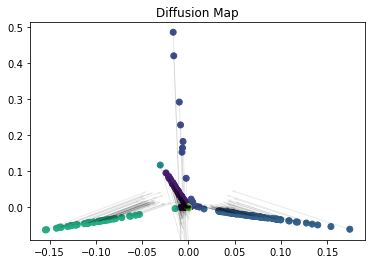

In [ ]:
def visualize_UW_dir_emb(coords, density, fields, labels):
    x = coords[:,0]
    y = coords[:,1]
    plt.scatter(x, y, c = labels)
    # plot only a fraction of the vectors, so as not to blot everything out
    mask = np.random.rand(len(fields)) > 0.25
    plt.quiver(x[mask], y[mask], fields[:,0][mask], fields[:,1][mask], alpha=0.1)
    plt.title("Diffusion Map")
visualize_UW_dir_emb(coords, density, velocities, labels)

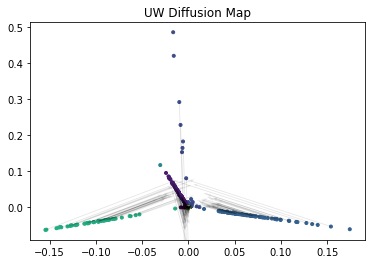

In [ ]:
from FRED.datasets import plot_directed_2d
plot_directed_2d(coords, velocities, labels, equal_aspect_ratio=False, title = "UW Diffusion Map")

# Qualitative analyses

We combine the embedded points with their velocities in the embedding space. 

In [ ]:
embedded_points = coords
embedded_velocities = velocities
points_and_flows = np.concatenate([embedded_points, embedded_velocities], axis=1)
points_and_flows.shape

(2930, 4)

In [ ]:
import sklearn 
silhouette_points = sklearn.metrics.silhouette_score(embedded_points, labels)
silhouette_points_and_flows = sklearn.metrics.silhouette_score(points_and_flows, labels)

## Nearest Neighbors Classifier Score

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(points_and_flows, labels, test_size=0.33, random_state=42)

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
neighClass = KNeighborsClassifier(n_neighbors=3)
neighClass.fit(X_train, y_train)
knn_classifier_score = neighClass.score(X_test, y_test)

In [ ]:
print(f"## SCORES ## \n silhouette score w/o flows: {silhouette_points}.\n silhouette score w/ flows:  {silhouette_points_and_flows} \n kNN Classifier {knn_classifier_score}")

## SCORES ## 
 silhouette score w/o flows: -0.08988252107985382.
 silhouette score w/ flows:  -0.08988252240227022 
 kNN Classifier 0.6494312306101344


# Write results to spreadsheet

In [ ]:
# create unique identifier for notebook
import secrets
import string
alphabet = string.ascii_letters + string.digits
unid = ''.join(secrets.choice(alphabet) for i in range(20))  # for a 20-character password
unid

'veXVDhcjcxkxmUoCbfUb'

In [ ]:
import csv
spread_name = notebook
with open(f"{spread_name}.csv", 'a') as csv_file:
    writer = csv.writer(csv_file)
    writer.writerow(
        [unid, 
         sigma, 
         num_neighbors,
         silhouette_points,
         silhouette_points_and_flows,
         knn_classifier_score
        ]) 